Target shape: itkSize3 ([256, 256, 256])
Target spacing: itkVectorD3 ([1, 1, 1])
Target direction: itkMatrixD33 ([[0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, -1.0, 0.0]])
Source shape: itkSize3 ([512, 512, 179])
Source spacing: itkVectorD3 ([0.98, 0.98, 2.5])
Source direction: itkMatrixD33 ([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
Source image needs to be resampled to match the target image.


__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.


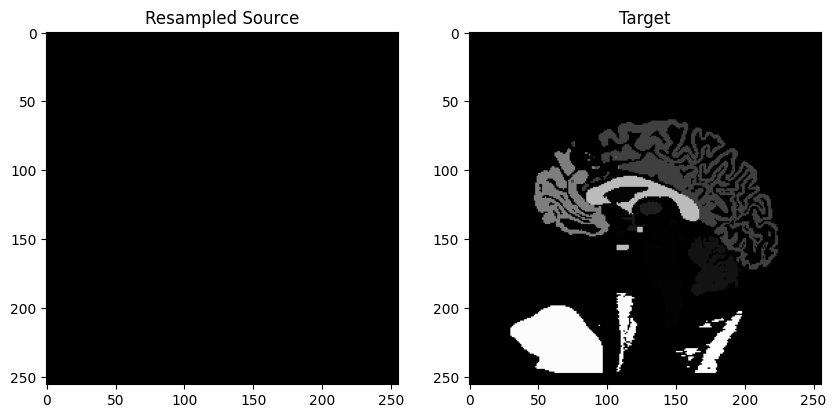

In [6]:
import numpy as np
import itk
import matplotlib.pyplot as plt

# Paths to the source and target NRRD files
target_path = "/home/sasaigoli/Documents/unigradicon/brain-2017-01/volumes/labels/hncma-atlas.nrrd"
source_path = "/home/sasaigoli/Documents/unigradicon/Brain.nrrd"

# Read the images using ITK
target_itk = itk.imread(target_path)
source_itk = itk.imread(source_path)

# Get the metadata for source and target
target_spacing = target_itk.GetSpacing()
target_direction = target_itk.GetDirection()
target_size = target_itk.GetLargestPossibleRegion().GetSize()

source_spacing = source_itk.GetSpacing()
source_direction = source_itk.GetDirection()
source_size = source_itk.GetLargestPossibleRegion().GetSize()

# Print out the shapes and orientation for debugging
print(f"Target shape: {target_size}")
print(f"Target spacing: {target_spacing}")
print(f"Target direction: {target_direction}")

print(f"Source shape: {source_size}")
print(f"Source spacing: {source_spacing}")
print(f"Source direction: {source_direction}")

# Define a resampling method to match source with target orientation
def resample_image_to_target(source_image, target_image):
    resampler = itk.ResampleImageFilter.New(Input=source_image)
    resampler.SetOutputSpacing(target_image.GetSpacing())
    resampler.SetSize(target_image.GetLargestPossibleRegion().GetSize())
    resampler.SetOutputDirection(target_image.GetDirection())
    resampler.SetOutputOrigin(target_image.GetOrigin())
    resampler.SetDefaultPixelValue(0)  # Set default pixel value for areas not covered by the input image
    resampler.SetTransform(itk.IdentityTransform[itk.D, 3].New())  # Use identity transform as no other transformation is needed
    resampler.Update()  # Update the resampler to perform the resampling
    return resampler.GetOutput()

# Check whether the orientation and spacing of the images are the same
if not np.array_equal(np.array(target_direction), np.array(source_direction)) or not np.array_equal(np.array(target_spacing), np.array(source_spacing)):
    print("Source image needs to be resampled to match the target image.")
    source_resampled_itk = resample_image_to_target(source_itk, target_itk)
else:
    print("Source image already matches the target orientation and spacing.")
    source_resampled_itk = source_itk

# Convert ITK images to NumPy arrays for visualization
target_np = itk.GetArrayFromImage(target_itk)
source_resampled_np = itk.GetArrayFromImage(source_resampled_itk)

# Visualize the resampled images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(source_resampled_np[source_resampled_np.shape[0] // 2], cmap='gray')
axes[0].set_title('Resampled Source')
axes[1].imshow(target_np[target_np.shape[0] // 2], cmap='gray')
axes[1].set_title('Target')
plt.show()


In [11]:
# Processing images
import torch
import torch.nn.functional as F
import numpy as np

def preprocess(img, type="ct"):
    if type == "ct":
        clamp = [-1000, 1000]
        img = (torch.clamp(img, clamp[0], clamp[1]) - clamp[0]) / (clamp[1] - clamp[0])
        # Interpolate to the required shape including batch and channel dimensions
        return F.interpolate(img, size=(1, 175, 175, 175), mode="trilinear", align_corners=False)
    elif type == "mri":
        # Convert to NumPy to calculate quantile efficiently
        img_np = img.cpu().numpy()  # Ensure the data is on the CPU
        im_min = torch.min(img)
        im_max = torch.tensor(np.quantile(img_np, 0.99))  # Calculate 99th percentile using NumPy
        img = torch.clip(img, im_min, im_max)
        img = (img - im_min) / (im_max - im_min)
        # Interpolate to the required shape including batch and channel dimensions
        return F.interpolate(img, size=(1, 175, 175, 175), mode="trilinear", align_corners=False)
    else:
        print(f"Error: Do not support the type {type}")
        return img

# Convert the target and source images to torch Tensors and preprocess
target = preprocess(torch.Tensor(np.array(target)).unsqueeze(0).unsqueeze(0), type="mri")
source = preprocess(torch.Tensor(np.array(source)).unsqueeze(0).unsqueeze(0), type="mri")

print(f"Processed target shape: {target.shape}")
print(f"Processed source shape: {source.shape}")


__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [1, 1, 175, 175, 175] and output size of (1, 175, 175, 175). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [12]:
from unigradicon import get_unigradicon
net = get_unigradicon()
net.cuda()
net.eval()
print()

ModuleNotFoundError: No module named 'unigradicon'

In [ ]:
with torch.no_grad():
  net(source.cuda(), target.cuda())

In [ ]:
def show_as_grid_contour(ax, phi, linewidth=1, stride=8, flip=False):
    data_size = phi.size()[1:]
    plot_phi = phi.cpu() - 0.5
    N = plot_phi.size()[-1]
    ax.contour(plot_phi[1], np.linspace(0, N, int(N/stride)), linewidths=linewidth, alpha=0.8)
    ax.contour(plot_phi[0], np.linspace(0, N, int(N/stride)), linewidths=linewidth, alpha=0.8)
    if flip:
        ax.set_ylim([0, data_size[0]])

def show_pair(source, target, warped, phi, axes, idx, flip=False):
    phi_scaled = phi * (torch.tensor((175, 175, 175), dtype=torch.float32).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)-1)
    if flip:
        origin = 'lower'
    else:
        origin = 'upper'
    axes[0].imshow(source.cpu()[0,0,idx], cmap="gray", origin=origin)
    axes[1].imshow(target.cpu()[0,0,idx], cmap="gray", origin=origin)
    axes[2].imshow(warped.cpu()[0,0,idx], cmap="gray", origin=origin)
    axes[3].imshow(target.cpu()[0,0,idx], cmap="gray", origin=origin)
    show_as_grid_contour(axes[3], phi_scaled[0, [1,2], idx], linewidth=0.6, stride=4, flip=flip)
    axes[4].imshow(target.cpu()[0,0,idx]-source.cpu()[0,0,idx], origin=origin)
    axes[5].imshow(target.cpu()[0,0,idx]-warped.cpu()[0,0,idx], origin=origin)

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(12,2))
show_pair(source, target, net.warped_image_A, net.phi_AB_vectorfield.cpu(), axes, 100)

font_size = 10
axes[0].set_title('Source', fontsize=font_size)
axes[1].set_title('Target', fontsize=font_size)
axes[2].set_title('Warped', fontsize=font_size)
axes[3].set_title('Target+Grids', fontsize=font_size)
axes[4].set_title('Difference Before', fontsize=font_size)
axes[5].set_title('Difference After', fontsize=font_size)
for axe in axes:
  axe.set_xticks([])
  axe.set_yticks([])
plt.show()

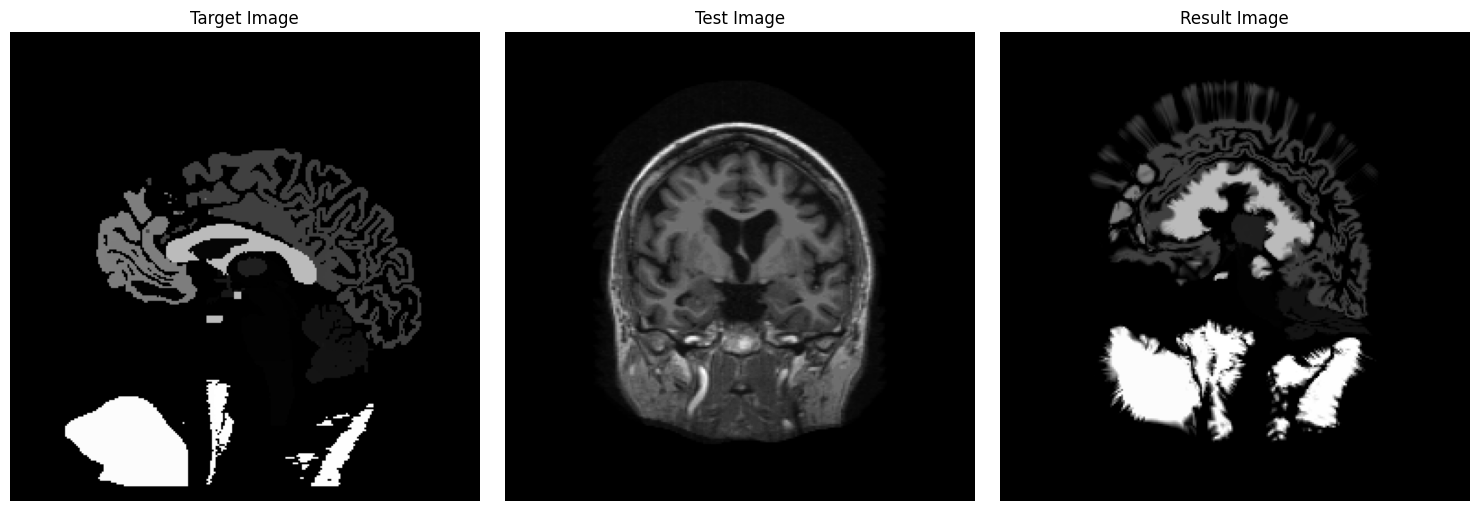

In [6]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# Define the file paths for the target, test, and result images
target_path = "/home/sasaigoli/Documents/unigradicon/brain-2017-01/volumes/labels/hncma-atlas.nrrd"
test_path = "/home/sasaigoli/Documents/oas1.nii.gz"
result_path = "/home/sasaigoli/Documents/unigradicon/warped_C01_2.nrrd"

# Function to load NRRD image and convert to NumPy array
def load_nrrd_image(filepath):
    itk_image = sitk.ReadImage(filepath)
    np_image = sitk.GetArrayFromImage(itk_image)
    return np_image

# Load the images using the function
target = load_nrrd_image(target_path)
test = load_nrrd_image(test_path)
result = load_nrrd_image(result_path)

# Choose a slice to visualize (e.g., middle slice)
slice_index = target.shape[0] // 2

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the images
axes[0].imshow(target[slice_index], cmap='gray')
axes[0].set_title('Target Image')
axes[0].axis('off')  # Turn off axis

axes[1].imshow(test[slice_index], cmap='gray')
axes[1].set_title('Test Image')
axes[1].axis('off')  # Turn off axis

axes[2].imshow(result[slice_index], cmap='gray')
axes[2].set_title('Result Image')
axes[2].axis('off')  # Turn off axis

# Show the figure
plt.tight_layout()
plt.show()


In [ ]:
unigradicon-register --fixed=/home/sasaigoli/Documents/oas1.nii.gz --fixed_modality=mri --moving=/home/sasaigoli/Documents/unigradicon/brain-2017-01/volumes/labels/hncma-atlas.nii.gz --moving_modality=mri --transform_out=trans.hdf5 --warped_moving_out=warped_oas1_2.nii.gz

In [8]:
import SimpleITK as sitk

# Define file paths
input_nrrd_path = "/home/sasaigoli/Documents/unigradicon/brain-2017-01/volumes/labels/hncma-atlas.nrrd"
output_nii_path = "/home/sasaigoli/Documents/unigradicon/brain-2017-01/volumes/labels/hncma-atlas.nii.gz"

# Read the NRRD file using SimpleITK
image = sitk.ReadImage(input_nrrd_path)

# Write the image to NIfTI format
sitk.WriteImage(image, output_nii_path)

print(f"Converted {input_nrrd_path} to {output_nii_path}")


Converted /home/sasaigoli/Documents/unigradicon/brain-2017-01/volumes/labels/hncma-atlas.nrrd to /home/sasaigoli/Documents/unigradicon/brain-2017-01/volumes/labels/hncma-atlas.nii.gz


In [9]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA available: False
Number of GPUs: 1


/home/sasaigoli/anaconda3/envs/unigradicon/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.